# NLP

In [1]:
import re
from string import punctuation, digits, ascii_lowercase

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import (train_test_split,cross_val_score,
                                      StratifiedShuffleSplit)
                                      
%matplotlib inline

In [2]:
reviews = pd.read_csv('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.csv')

In [31]:
samp = reviews.sample(n=10000)

Define lists of escape sequences, digits, stopwords to use for parseing. Also defines the type of stemming to be used. 

In [4]:
escapes = ''.join([chr(char) for char in range(1, 32)])
removeables = escapes + digits 
stops = [str(word) for word in stopwords.words('english')] + list(ascii_lowercase)
sno = nltk.stem.SnowballStemmer('english')

Create function to process the text and then use it to make a new coloumn in the dataframe where all texted has been processed. 

In [41]:
def parse_text(text, stem=True):
    ''' This function takes a review string and removes all escape sequences,
        digits, punctuation, http links, and stop words. Furthermore, every
        word in the string will be stemmed using nltk's snowball stemmer.
        Every word is also transformed to be lowercase.'''
    
    text = re.sub(r"http\S+", " ", text)
    regex = re.compile('[%s]' % re.escape(punctuation))
    text = regex.sub(' ', text)
    text = text.translate(None, removeables)
    text = text.decode('utf8')
    if stem == True:
        text = ' '.join([sno.stem(word.lower()) for word in text.split() if word.lower() not in set(stops)])
    else:
        text = ' '.join([word.lower() for word in text.split() if word.lower() not in set(stops)])
    return text

In [42]:
samp['parsed_text']=samp.text.apply(parse_text,stem=False)

### Bag of words, tf-idf vectorization
Create the bag of words representation. Find counts of each word in document and in whole courpus. Then create the tfidf representation. Worth also considering binary count vecorizing, supposed to work better for smaller sample sets.

In [46]:
corpus = samp.parsed_text.tolist()

In [47]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(corpus)

In [48]:
words = count_vect.get_feature_names()

In [45]:
# len(words) = 20197

In [49]:
len(words)

29078

In [50]:
np.array(words)[:35]

array([u'aa', u'aaa', u'aaaaaaaaaah', u'aaaaaaagh', u'aaaaaah',
       u'aaaaahhhh', u'aaaah', u'aaah', u'aamco', u'aand', u'aargh',
       u'aaron', u'aay', u'ab', u'aback', u'abagail', u'abandon',
       u'abandoned', u'abba', u'abbe', u'abbey', u'abbeyhill', u'abbiamo',
       u'abbondante', u'abbreviated', u'abc', u'abdc', u'abdominal',
       u'abdul', u'abend', u'abendessen', u'abends', u'aber',
       u'abercrombie', u'abides'], 
      dtype='<U46')

### Exploring count data

In [ ]:
pd.DataFrame()

In [51]:
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)

In [52]:
y = np.array(samp.stars.tolist())

### Train-Test split

Need to split the dataset into train and test, then use cross val to traing the classifier.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,
                                                    stratify=y)

In [ ]:
sss = StratifiedShuffleSplit(y_train, 5, test_size=0.3, random_state=0)

### Training a classifier

In [54]:
mnb = MultinomialNB().fit(X_train,y_train)

In [55]:
preds = mnb.predict(X_test)

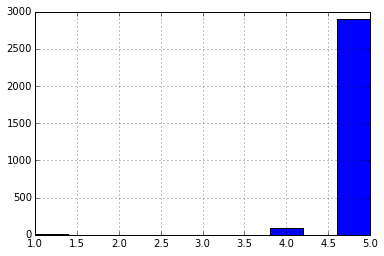

In [56]:
pd.Series(preds).hist()

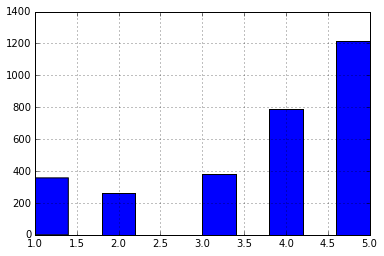

In [57]:
pd.Series(y_test).hist()

### Accuracy Metrics

importnatn to consider what is the best accuracy measure to use to test results. notice that star rating is a ordered 